In [9]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import csv
from pathlib import Path

torch.manual_seed(0)
device = "cpu"


In [10]:
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
EXP_DIR = Path("../experiments")

MODEL_DIR.mkdir(exist_ok=True)
EXP_DIR.mkdir(exist_ok=True)


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(
    root=DATA_DIR, train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root=DATA_DIR, train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


100.0%
100.0%
100.0%
100.0%


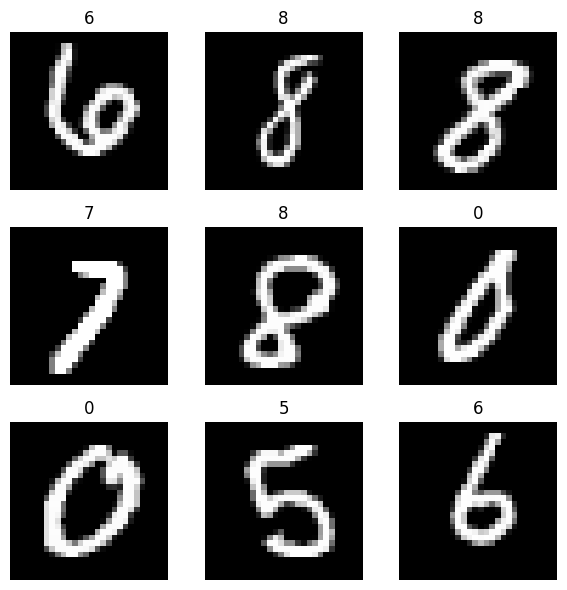

In [12]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(labels[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show()


In [13]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

model = FFN().to(device)


In [14]:
def train(model, loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss={total_loss/len(loader):.4f}")
def train(model, loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss={total_loss/len(loader):.4f}")

train(model, train_loader, epochs=5)

Epoch 1: loss=0.2298
Epoch 2: loss=0.0945
Epoch 3: loss=0.0646
Epoch 4: loss=0.0503
Epoch 5: loss=0.0373


In [15]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    start = time.time()

    with torch.no_grad():
        for x, y in loader:
            out = model(x.to(device))
            pred = out.argmax(dim=1)
            correct += (pred == y.to(device)).sum().item()
            total += y.size(0)

    latency = (time.time() - start) / total
    return correct / total, latency


In [16]:


acc, latency = evaluate(model, test_loader)
torch.save(model.state_dict(), MODEL_DIR / "ffn_baseline.pth")

print("Accuracy:", acc)
print("Latency (sec/sample):", latency)


Accuracy: 0.9784
Latency (sec/sample): 0.0007222573280334472


In [17]:
temp = MODEL_DIR / "tmp.pth"
torch.save(model.state_dict(), temp)
size_kb = os.path.getsize(temp) / 1024
temp.unlink()

print("Model size (KB):", size_kb)


Model size (KB): 921.1611328125


In [18]:
csv_path = EXP_DIR / "results.csv"

write_header = not csv_path.exists()

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Model", "Accuracy", "Size", "Latency"])
    writer.writerow(["FFN Baseline", acc, size_kb, latency])
